In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from ipywidgets import interact, fixed, FloatSlider, IntSlider
%matplotlib inline

In [2]:

# import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode #,plot,iplot
import plotly.graph_objects as go

init_notebook_mode(connected=True)
# cf.go_offline()

In [3]:
# load data and apply filters
# the sort_index calls are unnecessary but helps when visually comparing 2 tables side-by-side
data = pd.read_feather('../data/ESG_wdi.feather')
data = data[(data.date>=2000)&(data.date<=2018)]

# calculate an MRV table with indicators as rows and countries and columns
mrv = data.pivot_table(index='indicatorID',columns='iso3c',values='date',aggfunc=max).sort_index(axis=1)

nIndicators = len(mrv.index)
nCountries  = len(mrv.columns)
'{} indicators, {} countries'.format(nIndicators, nCountries)

'115 indicators, 217 countries'

In [4]:
# here's what the layout looks like
mrv.head()

iso3c,ABW,AFG,AGO,ALB,AND,ARE,ARG,ARM,ASM,ATG,...,VGB,VIR,VNM,VUT,WSM,XKX,YEM,ZAF,ZMB,ZWE
indicatorID,,,,,,,,,,,,,,,,,,,,,
AG.LND.AGRI.ZS,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,...,2016.0,2016.0,2016.0,2016.0,2016.0,2007.0,2016.0,2016.0,2016.0,2016.0
AG.LND.FRST.ZS,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,2016.0,...,2016.0,2016.0,2016.0,2016.0,2016.0,NaN,2016.0,2016.0,2016.0,2016.0
AG.LND.TOTL.K2,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,2018.0,...,2018.0,2018.0,2018.0,2018.0,2018.0,2017.0,2018.0,2018.0,2018.0,2018.0
AG.PRD.FOOD.XD,NaN,2016.0,2016.0,2016.0,NaN,2016.0,2016.0,2016.0,2016.0,2016.0,...,2016.0,2016.0,2016.0,2016.0,2016.0,NaN,2016.0,2016.0,2016.0,2016.0
BN.CAB.XOKA.GD.ZS,2016.0,2018.0,2018.0,2018.0,NaN,NaN,2018.0,2018.0,NaN,2018.0,...,NaN,NaN,2018.0,2018.0,2018.0,2018.0,2016.0,2018.0,2018.0,2017.0


In [5]:
# scale values to a 0:1 range at the country/series level

## calculate mins and maxes for each country/series
mm = data.groupby(['indicatorID', 'iso3c']).value.agg([np.min, np.max])
data = data.merge(mm, left_on=['indicatorID', 'iso3c'], right_index=True)
data['value2'] = (data.value-data.amin) / (data.amax-data.amin)

# where max==min the scaled result will be NaN. We set this to 0.5 for compatibility with R
data.loc[(pd.isna(data.value)==False) & pd.isna(data.value2), 'value2'] = 0.5

Here we create a similar pivot table but with CV values. For compatibility with R
we calculate the sample standard deviation (dof=N-1) instead of the population standard
deviation (dof=N).
The R code includes an alternate (slower) function to calculate the population stdev, so
we could switch if we so decide, so long as the approaches are consistent.

Series with only 1 element will produce a CV of either 0 or NaN depending on dof. Neither is acceptable
but NaN is particularly problematic since it results in the ensuing calculations producing fewer
observations than with no extrapolations. Instead the CV function returns a very high value
so that the corresponding series will never be extrapolated, leaving the original MRV.

In [6]:
def cv(s):
    m = np.mean(s)
    if m == 0:
        return np.nan   # avoid div/0
    elif len(s) == 1:
        return np.inf      # return a CV value high enough that it will never be extrapolated
    
    return np.std(s, ddof=1) / m

cvs = data.pivot_table(index='indicatorID', columns='iso3c', values='value2', aggfunc=cv).sort_index(axis=1)
'{} indicators, {} countries'.format(len(cvs.index), len(cvs.columns))

'115 indicators, 217 countries'

In [7]:
# confirm we're consistent with the R tools by calculating quintiles
flat_cvs = pd.melt(cvs)
flat_cvs = flat_cvs[flat_cvs.value!=np.inf]
qt = flat_cvs.quantile([0, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 1]).value
qt.round(3)

0.00    0.000
0.05    0.000
0.10    0.375
0.25    0.551
0.50    0.688
0.75    0.873
0.90    1.204
0.95    1.414
1.00    4.243
Name: value, dtype: float64

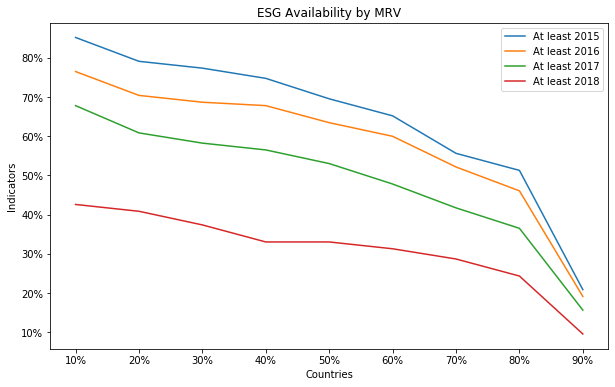

In [8]:
# recreate the MRV availability chart from the first report
fig, ax = plt.subplots(figsize=(10,6))
plt.title('ESG Availability by MRV')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel('Indicators')
ax.set_xlabel('Countries')

x = np.arange(0.1,1,0.1)

for year in range(2015,2019):
    y = list()
    for t in x:
        y.append((mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries >= t).sum()/nIndicators)
    
    plt.plot(x, y, label='At least {}'.format(year))

plt.legend()
print()

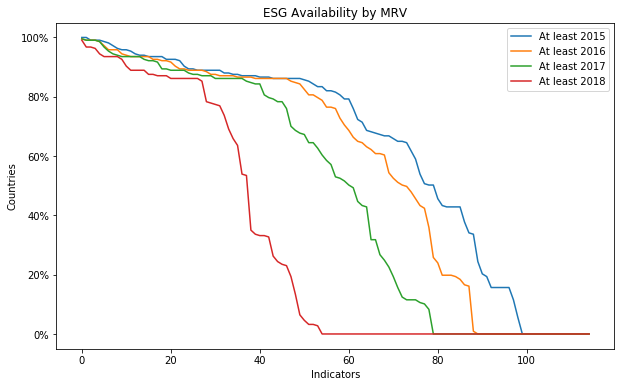

In [9]:
# Here's the same chart but with axes swapped and indicators in absolute counts to match the interactive tool below

# recreate the MRV availability chart from the first report
fig, ax = plt.subplots(figsize=(10,6))
plt.title('ESG Availability by MRV')
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
ax.set_ylabel('Countries')
ax.set_xlabel('Indicators')

x = range(nIndicators)

for year in range(2015,2019):
    y = (mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries).sort_values(ascending=False)    
    plt.plot(x, y, label='At least {}'.format(year))

plt.legend()
print()

We can calculate a coverage score *V* b/t 0 and 1 for a given year *y* as follows:

$$V_y = \frac{\sum_{i=1}^C \sum_{j=1}^S \left[M_{ij}>=y\right]}{CS}$$

* $S$ = number of indicators
* $C$ = number of countries
* $M$ = MRV for country $i$ and series $j$

This is the same as "area under the curve" in the charts above and below

In [10]:
# calculate baseline score for 2018
year = 2018
nYears = mrv.apply(lambda x: x>=year).to_numpy().sum()
'{}: {}'.format(nYears, nYears/(nIndicators * nCountries))


'7659: 0.3069124423963134'

In [14]:
# Here we calculate the effect of imputing the MRV ahead by a number of
# years for any cv below a threshold

def estimate_model_obs(year=2018, cv_max=0.5, years_to_extrapolate=1):

    test_mrv = mrv + cvs.applymap(lambda x: years_to_extrapolate if x<=cv_max else 0)
    return test_mrv.apply(lambda x: x>=year).to_numpy().sum()

def estimate_model_impact(year=2018, cv_max=0.5, years_to_extrapolate=1):


    return estimate_model_obs(year, cv_max, years_to_extrapolate)/(nIndicators * nCountries)

examples = pd.DataFrame({'Year': [2018, 2018, 2018, 2018, 2018],
                         'Quantile': [0, 0.25, 0.5, 0.75, 0.75],
                         'CV Threshold': 0,
                         'Years To Extrapolate': [0, 1, 1, 1, 2]})

examples['CV Threshold'] = examples['Quantile'].apply(lambda x: qt[x])
examples['Obs'] = examples.apply(lambda x: estimate_model_obs(x['Year'], x['CV Threshold'], x['Years To Extrapolate']), axis=1)
examples['Coverage'] = examples.apply(lambda x: estimate_model_impact(x['Year'], x['CV Threshold'], x['Years To Extrapolate']), axis=1)
examples

,Year,Quantile,CV Threshold,Years To Extrapolate,Obs,Coverage
0,2018,0.00,0.000000,0,7659,0.306912
1,2018,0.25,0.550934,1,8559,0.342977
2,2018,0.50,0.687533,1,9615,0.385294
3,2018,0.75,0.872532,1,10732,0.430054
4,2018,0.75,0.872532,2,12542,0.502585


In [102]:
def mrv_plot(year=2018, cv_max=0.65, years_to_impute=1):
    
    # cv_max = 0.688
    annots = []
    # plot the unadjusted line as a reference
    m = pd.DataFrame((mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries),columns=['baseline'])
    z = data.set_index('indicatorID')[['indicator']].drop_duplicates()
    m['label'] = m.index.map(lambda x: z.loc[x].indicator)
    
    if years_to_impute > 0:
        test_mrv = mrv + cvs.applymap(lambda x: years_to_impute if x<=cv_max else 0)
        m['imputed'] = (test_mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries)
        m['gain'] = m['imputed'] - m['baseline']
        m.sort_values('imputed', ascending=False, inplace=True)
        
        chart_data = [
            go.Bar(name='Original Values<br>(n={}, AUC={:.2f})'. \
                   format(sum(m.baseline>0), m.baseline.sum()/nIndicators), x=m.label, y=m.baseline, marker_color="red"),
            go.Bar(name='With Imputation<br>(n={}, AUC={:.2f})'. \
                   format(sum(m.imputed>0), m.imputed.sum()/nIndicators), x=m.label, y=m.gain, marker_color="blue")            
        ]
                        
    else:
        m.sort_values('baseline', ascending=False, inplace=True)
        layout = go.Layout(xaxis=dict(showticklabels=False), yaxis=dict(tickformat=',.0%'))
        chart_data = [
            go.Bar(name='Original Values<br>(AUC={:.2f})'.format(m.baseline.sum()/nIndicators), x=m.label, y=m.baseline, marker_color="red")            
        ]
        
    layout = go.Layout(xaxis=dict(showticklabels=False), yaxis=dict(tickformat=',.0%'),hovermode='x')
    fig = go.Figure(data=chart_data, layout=layout)
    fig.update_layout(barmode="stack",
                      title='ESG Ranked Country Coverage for {}'.format(year),
                      xaxis_title="Indicators",
                      yaxis_title="Country Coverage",
                      legend=dict(x=0.8, y=0.95),
                      width=950, height=600,
                      annotations=[dict(
                          x=0.9, y=0.75,
                          text='<br>'.join(annots),
                          xref='paper', yref='paper', showarrow=False
                      )]
                      # hovermode='compare'
                     )
    fig.show()

interact(mrv_plot,
         year=IntSlider(min=2010,max=2019, value=2018, continuous_update=False),
         cv_max=FloatSlider(min=0.0,max=qt[1], value=0.5, step=0.05, continuous_update=False),
         years_to_impute=IntSlider(min=0,max=3, value=1, continuous_update=False))
#mrv_plot()
print()

interactive(children=(IntSlider(value=2018, continuous_update=False, description='year', max=2019, min=2010), …

This section allows you to define test parameters and see the result in terms of coverage improvement.

In [87]:
# input parameters
cv_max = 0.688
years_to_impute = 1
target_year = 2018
coverage_pct = 0.5

tmp = mrv
s = tmp.apply(lambda x: x>=target_year).sum(axis=1) / nCountries
baselineCoverage = len(s[s>=coverage_pct])

# now calculate the level of improvement, if we extrapolate values for observations above a given CV threshold
tmp = mrv + cvs.applymap(lambda x: years_to_impute if x<=cv_max else 0)
s2 = tmp.apply(lambda x: x>=target_year).sum(axis=1) / nCountries

# s2 > s gives an array of improved indicators. We can use this to query the original series
improvedIndicators = len(s[s2 > s])

reallyImprovedIndicators = len(s[(s2 > s) & (s == 0)])

improvedCoverage = len(s2[s2>=coverage_pct])

print('Total Indicators:                            {}'.format(nIndicators))
print('Indicators with MRV>={} (before/after):    {}/{}'.format(target_year, len(s[s>0]), len(s2[s2>0])))
print('Improved Indicators (previously 0%/all):     {}/{}'.format(reallyImprovedIndicators, improvedIndicators))
print('Indicators with 50% coverage (before/after): {}/{}'.format(baselineCoverage, improvedCoverage))

Total Indicators:                            115
Indicators with MRV>=2018 (before/after):    54/77
Improved Indicators (previously 0%/all):     23/51
Indicators with 50% coverage (before/after): 38/43


In [13]:
# other implementatons of the above

def mrv_calc(year,cv_max,years_to_impute):
    
    if cv_max > 0:
        test_mrv = mrv + cvs.applymap(lambda x: years_to_impute if x<=cv_max else 0)
    else:
        test_mrv = mrv
        
    return test_mrv.apply(lambda x: x>=year).to_numpy().sum()/(nIndicators * nCountries)

def mrv_plot1(year=2018, cv_max=0.5, years_to_impute=1):
    
    fig, ax = plt.subplots(figsize=(16,8))
    plt.title('ESG Ranked Country Coverage for {:.0f}'.format(year))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_ylabel('Country Coverage')
    ax.set_xlabel('Indicators')
    x = range(len(mrv.index))

    # plot the unadjusted line as a reference
    m = pd.DataFrame((mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries),columns=['baseline'])
    if cv_max > 0:
        test_mrv = mrv + cvs.applymap(lambda x: years_to_impute if x<=cv_max else 0)
        m['imputed'] = (test_mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries)
        m['gain'] = m['imputed'] - m['baseline']
        m.sort_values('imputed', ascending=False, inplace=True)
        plt.bar(x, m.baseline, color="red", label='Original Values\n(AUC={:.2f})'.format(m.baseline.sum()/nIndicators))
        plt.bar(x, m.gain, bottom=m.baseline, color="blue", label='With Imputation\n(AUC={:.2f})'.format(m.imputed.sum()/nIndicators))

        # plt.annotate('AUC={:0.2f}'.format(m.baseline.sum()/nIndicators), xy=(0,0), xytext=(nIndicators, 0.85), color="red", ha="right")
        # plt.annotate('AUC={:0.2f}'.format(m.imputed.sum()/nIndicators), xy=(0,0), xytext=(nIndicators, 0.82), color="blue", ha="right")
        
    else:
        m.sort_values('baseline', ascending=False, inplace=True)
        plt.bar(x, m.baseline, color="red", label='Original Values\n(AUC={:.2f})'.format(m.baseline.sum()/nIndicators))
        

    plt.legend()
    
def mrv_plot2(year=2018, cv_max=0.5, years_to_impute=1):
    
    fig, ax = plt.subplots(figsize=(16,8))
    plt.title('ESG Ranked Country Coverage for {:.0f}'.format(year))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))
    ax.set_ylabel('Country Coverage')
    ax.set_xlabel('Indicators')
    x = range(len(mrv.index))
        
    if cv_max > 0:
        test_mrv = mrv + cvs.applymap(lambda x: years_to_impute if x<=cv_max else 0)
        y = (test_mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries).sort_values(ascending=False)
        plt.fill_between(x, y,alpha=0.25)
        plt.plot(x, y, label='With Imputation', color="blue")
        plt.annotate('AUC={:0.2f}'.format(y.sum()/nIndicators), xy=(0,0), xytext=(2,0.07), color="blue")

    # plot the unadjusted line as a reference
    y = (mrv.apply(lambda x: x>=year).sum(axis=1)/nCountries).sort_values(ascending=False)
    plt.plot(x, y, color="red", label='Original values')
    plt.annotate('AUC={:0.2f}'.format(y.sum()/nIndicators), xy=(0,0), xytext=(2,0.02), color="red")
    plt.legend()

# mrv_plot1()
# mrv_plot2()